
## 기본모델 가져오기
IMDb 영화 리뷰 데이터를 사용해 텍스트를 이진 분류하는 간단한 신경망 모델을 구축

In [7]:
# 필수 라이브러리 임포트
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.datasets import imdb  # IMDb 데이터셋
from tensorflow.keras.models import Sequential  # 모델 생성
from tensorflow.keras.layers import Dense  # Dense Layer
from tensorflow.keras.callbacks import EarlyStopping  # 조기 종료
import numpy as np  # 데이터 전처리 및 벡터화
import matplotlib.pyplot as plt  # 시각화
import seaborn as sns  # 혼동 행렬 시각화
from sklearn.metrics import confusion_matrix  # 혼동 행렬 계산

In [8]:
# Set random seed for reproducibility
np.random.seed(42)

# IMDb 데이터셋 로드 (10000개의 자주 사용되는 단어로 제한)
# IMDb 데이터셋 로드 및 전처리
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.imdb.load_data(num_words=10000)

# 벡터화 함수 정의
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))  # 0으로 초기화된 배열 생성
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # 단어 인덱스 위치에 1 설정
    return results

# 데이터 벡터화
train_data = vectorize_sequences(train_data)
test_data = vectorize_sequences(test_data)

# 모델 생성: 3개의 Dense 층으로 구성된 신경망
model = keras.models.Sequential([
    layers.Dense(16, activation="relu"),  # 첫 번째 은닉층: 16개의 뉴런, ReLU 활성화 함수
    layers.Dense(16, activation="relu"),  # 두 번째 은닉층: 16개의 뉴런, ReLU 활성화 함수
    layers.Dense(1, activation="sigmoid") # 출력층: 1개의 뉴런, Sigmoid 활성화 함수 (이진 분류용)
])



AUC 정의

In [9]:

# 사용자 정의 AUCMetric 클래스 정의
class AUCMetric(tf.keras.metrics.Metric):
    def __init__(self, name='auc', **kwargs):
        """
        AUC(Area Under the Curve) 계산을 위한 사용자 정의 Metric 클래스 초기화.

        매개변수:
        - name: Metric 이름 (기본값: 'auc').
        - **kwargs: 추가적인 매개변수.
        """
        super().__init__(name=name, **kwargs)
        # Confusion Matrix의 각 요소를 저장하기 위한 상태 변수 초기화
        self.true_positives = self.add_weight(name='tp', initializer='zeros')  # True Positive
        self.false_positives = self.add_weight(name='fp', initializer='zeros')  # False Positive
        self.true_negatives = self.add_weight(name='tn', initializer='zeros')  # True Negative
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')  # False Negative

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Confusion Matrix의 상태를 업데이트.

        매개변수:
        - y_true: 실제 레이블 (0 또는 1).
        - y_pred: 예측값 (0과 1 사이의 값).
        - sample_weight: 선택적 샘플 가중치.
        """
        # y_pred 값을 0.5 이상이면 1로, 그렇지 않으면 0으로 변환 (이진 분류)
        y_pred = tf.cast(y_pred >= 0.5, tf.int32)
        y_true = tf.cast(y_true, tf.int32)

        # Confusion Matrix 각 요소 계산
        tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))  # True Positive
        fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))  # False Positive
        tn = tf.reduce_sum(tf.cast((1 - y_true) * (1 - y_pred), tf.float32))  # True Negative
        fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))  # False Negative

        # 상태 변수 업데이트
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.true_negatives.assign_add(tn)
        self.false_negatives.assign_add(fn)

    def result(self):
        """
        AUC 값을 계산.

        반환값:
        - AUC 값 (TPR과 FPR을 사용하여 계산).
        """
        # True Positive Rate (TPR) 계산: TP / (TP + FN)
        tpr = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())

        # False Positive Rate (FPR) 계산: FP / (FP + TN)
        fpr = self.false_positives / (self.false_positives + self.true_negatives + tf.keras.backend.epsilon())

        # TPR과 FPR을 사용하여 AUC 계산
        return (tpr + (1 - fpr)) / 2

    def reset_states(self):
        """
        상태 변수 초기화.

        각 에포크 또는 훈련 반복에서 Confusion Matrix 상태를 0으로 재설정.
        """
        self.true_positives.assign(0.0)
        self.false_positives.assign(0.0)
        self.true_negatives.assign(0.0)
        self.false_negatives.assign(0.0)



PPV class 정의







In [10]:
class PPVMetric(tf.keras.metrics.Metric):
    def __init__(self, name='ppv', **kwargs):
        """
        양성 예측도(Positive Predictive Value, PPV) 계산을 위한 사용자 정의 Metric 클래스.

        매개변수:
        - name: Metric 이름 (기본값: 'ppv').
        - **kwargs: 추가 매개변수.
        """
        super().__init__(name=name, **kwargs)
        # Confusion Matrix의 True Positive와 False Positive를 저장할 상태 변수 초기화
        self.true_positives = self.add_weight(name='tp', initializer='zeros')  # True Positive
        self.false_positives = self.add_weight(name='fp', initializer='zeros')  # False Positive

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Confusion Matrix의 상태를 업데이트.

        매개변수:
        - y_true: 실제 레이블 (0 또는 1).
        - y_pred: 예측값 (0과 1 사이의 값).
        - sample_weight: 선택적 샘플 가중치.
        """
        # 예측값(y_pred)을 임계값 0.5 기준으로 이진 분류 (0 또는 1로 변환)
        y_pred = tf.cast(y_pred >= 0.5, tf.int32)
        y_true = tf.cast(y_true, tf.int32)

        # True Positive(TP)와 False Positive(FP) 계산
        tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))  # TP: 실제 양성과 예측 양성이 일치한 경우
        fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))  # FP: 실제 음성을 양성으로 잘못 예측한 경우

        # 상태 변수 업데이트
        self.true_positives.assign_add(tp)  # TP 값을 기존 값에 추가
        self.false_positives.assign_add(fp)  # FP 값을 기존 값에 추가

    def result(self):
        """
        PPV 계산.

        반환값:
        - Precision(정밀도): TP / (TP + FP)
        """
        precision = self.true_positives / (
            self.true_positives + self.false_positives + tf.keras.backend.epsilon()
        )  # 분모가 0이 되는 것을 방지하기 위해 epsilon 추가
        return precision

    def reset_states(self):
        """
        상태 초기화.

        각 상태 변수(TP, FP)를 다음 평가를 위해 0으로 재설정.
        """
        self.true_positives.assign(0.0)  # TP 초기화
        self.false_positives.assign(0.0)  # FP 초기화


AUC, PPC 시각화 함수 정의

In [11]:
import matplotlib.pyplot as plt

def plot_metrics(history, metrics=["ppv", "auc"]):
    """
    훈련 기록에서 지정된 메트릭을 에포크별로 시각화.

    매개변수:
    - history: model.fit()에서 반환된 Keras 훈련 기록 객체.
    - metrics: 시각화할 메트릭 이름의 리스트.
    """
    for metric in metrics:
        metric_name = metric  # 메트릭 이름 (훈련 데이터 기준)
        val_metric_name = f"val_{metric}"  # 메트릭 이름 (검증 데이터 기준)

        # 메트릭이 history에 존재하는지 확인
        if metric_name not in history.history or val_metric_name not in history.history:
            print(f"Metric '{metric_name}' not found in history. Skipping.")
            continue

        # 에포크별 데이터 준비
        epochs = range(1, len(history.history[metric_name]) + 1)

        # 시각화
        plt.figure()
        plt.plot(epochs, history.history[metric_name], label=f"Training {metric_name}")
        plt.plot(epochs, history.history[val_metric_name], label=f"Validation {metric_name}")
        plt.title(f"{metric_name.upper()} by Epoch")
        plt.xlabel("Epochs")
        plt.ylabel(metric_name.upper())
        plt.legend()
        plt.show()




Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9623 - auc: 0.5148 - loss: 0.1506 - ppv: 0.5113 - val_accuracy: 0.8698 - val_auc: 0.5152 - val_loss: 0.3839 - val_ppv: 0.5090
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9808 - auc: 0.5143 - loss: 0.0641 - ppv: 0.5137 - val_accuracy: 0.8660 - val_auc: 0.5144 - val_loss: 0.4929 - val_ppv: 0.5093
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9896 - auc: 0.5138 - loss: 0.0377 - ppv: 0.5181 - val_accuracy: 0.8674 - val_auc: 0.5145 - val_loss: 0.6111 - val_ppv: 0.5085
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9950 - auc: 0.5171 - loss: 0.0214 - ppv: 0.5179 - val_accuracy: 0.8590 - val_auc: 0.5148 - val_loss: 0.7232 - val_ppv: 0.5102
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9941 - auc: 0.5157 - loss: 0.0210 - ppv: 0.5140 - val_accuracy: 0.8612 - val_auc: 0.5148 - val_loss: 0.7849 - val_ppv: 0.5086
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 

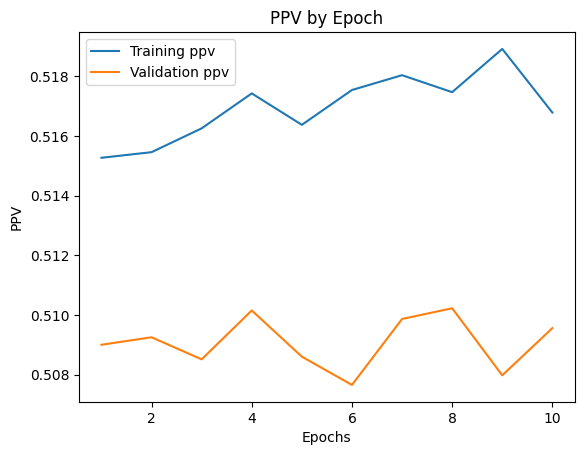

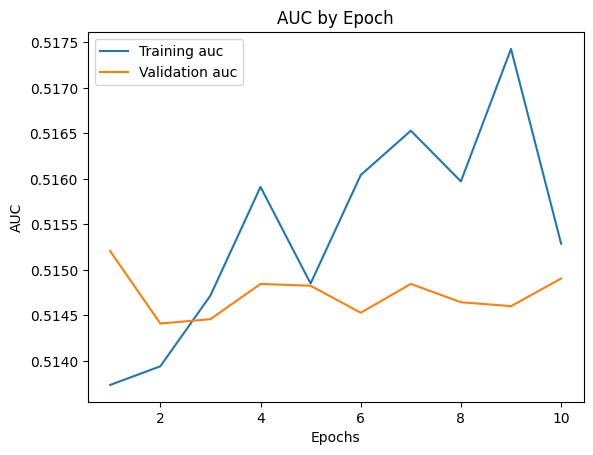

In [50]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", PPVMetric(name="ppv"), AUCMetric(name="auc")]
)

history = model.fit(train_data, train_labels, epochs=10, validation_split=0.2)

# 훈련 후 메트릭 시각화
plot_metrics(history, metrics=["ppv", "auc"])


TensorBoard 및 EarlyStopping 콜백 정의

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import datetime

# TensorBoard 로그 디렉토리 설정 (고유성을 위해 타임스탬프 포함)
log_dir = f"./logs/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"

# EarlyStopping 콜백 정의
early_stopping = EarlyStopping(
    monitor="val_loss",  # 모니터링할 평가 지표 (예: 'val_loss', 'val_accuracy' 등)
    patience=3,          # 성능 개선이 없을 때 학습을 멈추기까지의 에포크 수
    restore_best_weights=True  # 가장 좋은 성능을 나타낸 에포크의 가중치를 복원
)

# TensorBoard 콜백 정의
tensorboard_callback = TensorBoard(
    log_dir=log_dir,         # 로그를 저장할 디렉토리 경로
    histogram_freq=1         # 히스토그램을 생성할 빈도 (에포크 기준)
)


In [53]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[AUCMetric(name="auc"), PPVMetric(name="ppv")]  # AUC first
)

# Train the model with callbacks
history = model.fit(
    train_data,
    train_labels,
    epochs=50,               # Maximum epochs
    validation_split=0.2,    # 20% validation data
    callbacks=[early_stopping, tensorboard_callback]  # Use callbacks
)


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - auc: 0.5142 - loss: 0.0046 - ppv: 0.5126 - val_auc: 0.5141 - val_loss: 1.3247 - val_ppv: 0.5077
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - auc: 0.5164 - loss: 0.0024 - ppv: 0.5158 - val_auc: 0.5136 - val_loss: 1.2689 - val_ppv: 0.5079
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - auc: 0.5148 - loss: 6.3591e-04 - ppv: 0.5177 - val_auc: 0.5139 - val_loss: 1.3991 - val_ppv: 0.5080
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - auc: 0.5167 - loss: 7.5934e-05 - ppv: 0.5182 - val_auc: 0.5143 - val_loss: 1.4335 - val_ppv: 0.5086
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - auc: 0.5165 - loss: 4.2106e-05 - ppv: 0.5179 - val_auc: 0.5142 - val_loss: 1.4828 - val_ppv: 0.5084


Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.5143 - loss: 2.5129e-10 - ppv: 0.5210
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.5151 - loss: 2.1661e-10 - ppv: 0.5151
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc: 0.5147 - loss: 2.6931e-10 - ppv: 0.5128
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - auc: 0.5153 - loss: 2.2803e-10 - ppv: 0.5129
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - auc: 0.5142 - loss: 1.9788e-10 - ppv: 0.5136
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - auc: 0.5151 - loss: 1.5569e-10 - ppv: 0.5150
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.5172 - loss: 1.8249e-10 - ppv: 0.5168
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - auc: 0.5142 - loss: 1.5267e-10 - ppv: 0.5173
Epoch 9/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - auc: 0.5140 - loss: 1.6429e-10 - ppv: 0.5151
Epoch 10/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - auc: 0.5137 - loss: 1.6085e-10 - ppv: 0.5180
Epoch 11/

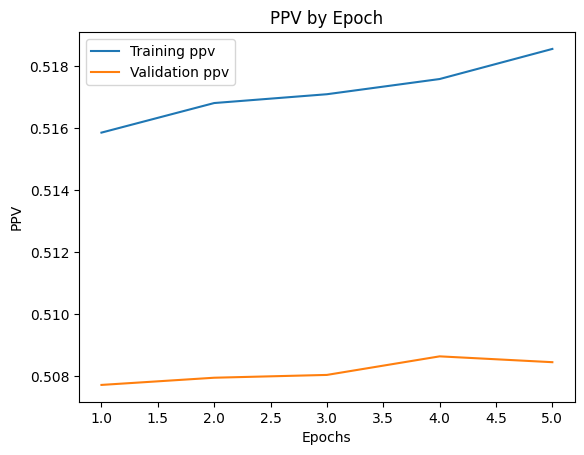

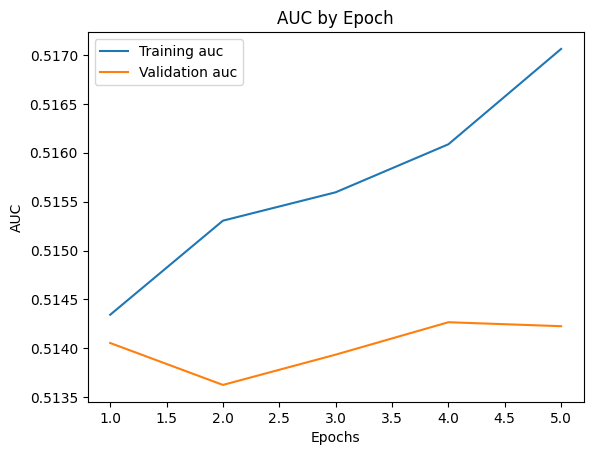

In [57]:
#학습 성능 저조로 인하여 모델 하이퍼파라미터 수정


class_weights = {0: 1.0, 1: 10.0}  # 클래스 0과 1에 가중치 적용
model.fit(train_data, train_labels, epochs=50, class_weight=class_weights)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # 학습률 낮추기
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[AUCMetric(name="auc"), PPVMetric(name="ppv")]  # AUC first
)

# 훈련 후 메트릭 시각화
plot_metrics(history, metrics=["ppv", "auc"])


AUC가 올라가지 않아 3차 수정

In [16]:

# 학습률 스케줄러 정의
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  # 초기 학습률
    decay_steps=1000,           # 1000 스텝마다 감소
    decay_rate=0.9              # 감소 비율: 0.9
)

# RMSprop 옵티마이저 정의
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

# 모델 정의 (구조 변경 없음)
model = Sequential([
    Dense(16, activation="relu", input_shape=(10000,)),  # 첫 번째 은닉층
    Dense(16, activation="relu"),                        # 두 번째 은닉층
    Dense(1, activation="sigmoid")                       # 출력층 (이진 분류)
])

# 모델 컴파일
model.compile(
    optimizer=optimizer,              # RMSprop 옵티마이저
    loss="binary_crossentropy",       # 손실 함수: 이진 교차 엔트로피
    metrics=[AUCMetric(name="auc")]  # 사용자 정의 메트릭 포함,  PPVMetric(name="ppv")제거
)

# EarlyStopping 콜백 정의
early_stopping = EarlyStopping(
    monitor="val_auc",                # 검증 AUC를 모니터링
    patience=3,                       # 3 에포크 동안 개선 없으면 중단
    mode="max",                       # AUC 값은 최대화가 목표
    restore_best_weights=True         # 가장 성능이 좋았던 가중치 복원
)

# 모델 학습
history = model.fit(
    train_data,
    train_labels,
    epochs=1000,                      # 최대 에포크 수
    batch_size=16,                    # 배치 크기
    validation_split=0.2,             # 검증 데이터: 20%
    #callbacks=[early_stopping]        # EarlyStopping 콜백 제거
)



# 훈련 후 메트릭 시각화
plot_metrics(history, metrics=[ "auc"])


Epoch 1/1000
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - auc: 0.5214 - loss: 0.4040 - val_auc: 0.5280 - val_loss: 0.2753
Epoch 2/1000
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - auc: 0.5273 - loss: 0.2085 - val_auc: 0.5292 - val_loss: 0.2838
Epoch 3/1000
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - auc: 0.5265 - loss: 0.1730 - val_auc: 0.5295 - val_loss: 0.3173
Epoch 4/1000
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - auc: 0.5289 - loss: 0.1482 - val_auc: 0.5283 - val_loss: 0.3296
Epoch 5/1000
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - auc: 0.5265 - loss: 0.1280 - val_auc: 0.5284 - val_loss: 0.3511
Epoch 6/1000
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - auc: 0.5250 - loss: 0.1162 - val_auc: 0.5280 - val_loss: 0.3698
Epoch 7/1000
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - auc: 0.5256 - loss: 0.0965 - val_auc: 0.5280 - val_loss: 0.4026
Epoch 8/1000
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - auc: 0.5321 - loss: 0.0928 - val_auc: 0.5280 - val_loss: 0.4467
Epoch 9/1000
1250/1250 

KeyboardInterrupt: 